**Wymagane pakiety:**
- `numpy`
- `matplotlib`

# Inicjalizacja

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.animation as anim
import functools, math, csv
from enum import Enum

plt.rcParams["animation.html"] = "jshtml"
plt.rcParams["figure.figsize"] = (8, 8)
plt.rcParams["lines.marker"] = ""
plt.rcParams["lines.markersize"] = 5

EPSILON = 10 ** -13

# Funkcje pomocnicze

In [2]:
def prepPlot():
    plt.close()
    plt.axis("equal")
    
def dist(a, b):
    return math.sqrt((b[0] - a[0]) ** 2 + (b[1] - a[1]) ** 2)
    
def unzip(polygon):
    if (len(polygon) > 0):
        return tuple(map(list, zip(*polygon)))
    else:
        return ([], [])

def enclose(l):
    return l + [l[0]]
    
def detOwn3(p0, p1, p2):
    return p0[0] * p1[1] + p1[0] * p2[1] + p2[0] * p0[1] - p2[0] * p1[1] - p1[0] * p0[1] - p0[0] * p2[1]
    
class Clockwiseness(Enum):
    CW, COLL, CCW = range(-1, 2)
    
    def getDirection(p0, p1, p2):
        det = detOwn3(p0, p1, p2)
        
        if det < -EPSILON:
            return Clockwiseness.CW
        elif det <= EPSILON:
            return Clockwiseness.COLL
        else:
            return Clockwiseness.CCW

def hasCollinearVertices(polygon):
    for i in range(len(polygon)):
        pred = polygon[(idx - 1) % len(polygon)]
        curr = polygon[idx]
        succ = polygon[(idx + 1) % len(polygon)]
        
        if Clockwiseness.getDirection(pred, curr, succ) == Clockwiseness.COLL:
            return True
    return False

def signum(x):
    if x < 0:
        return -1
    elif x == 0:
        return 0
    else:
        return 1

def higherOnLeftCmp(p1, p2):
    return signum(p2[1] - p1[1] if p1[1] != p2[1] else p1[0] - p2[0])

# Zapis do `.csv`

In [3]:
def saveToCsv(polygon, filename):
    with open(filename, 'w', newline="") as f:
        csvwriter = csv.writer(f)
        csvwriter.writerow(("x", "y"))
        for vertex in polygon:
            csvwriter.writerow(vertex)

# Odczyt z `.csv`

In [23]:
def readFromCsv(filename):
    with open(filename, newline="") as f:
        csvreader = csv.reader(f)
        readLines = list(csvreader)
        if len(readLines) > 0:
            return list(map(lambda pair: (float(pair[0]), float(pair[1])), readLines[1:]))
        else:
            return []

# Tworzenie wielokąta

In [17]:
class PolygonEditor:
    def __init__(self):
        plt.close()
        self.fig, self.ax = plt.subplots()
        self.fig.canvas.set_window_title("PolygonEditor")
        plt.subplots_adjust(bottom=0.2)
        
        self.reinit()
        
        self.filename = "file.csv"
        
        self.bpe = self.fig.canvas.mpl_connect("button_press_event", self.onclick)
        
        self.bClear = mpl.widgets.Button(plt.axes([0.15, 0.05, 0.1, 0.075]), "Clear")
        self.bClearE = self.bClear.on_clicked(self.clear)
        
        self.tFilename = mpl.widgets.TextBox(plt.axes([0.37, 0.05, 0.5, 0.075]), "Filename", initial=self.filename)
        self.tFilenameE = self.tFilename.on_text_change(self.onchange)
        
    def clearAx(self):
        self.ax.clear()
        self.ax.set_xlim((-10, 10))
        self.ax.set_ylim((-10, 10))
        
    def reinit(self):
        self.polygon = []
        self.clearAx()
        
    def onclick(self, event):
        self.polygon.append((event.xdata, event.ydata))
        if (len(self.polygon) > 2 and dist(self.polygon[0], self.polygon[-1]) < 0.5):
            self.polygon.pop()
            saveToCsv(self.polygon, self.filename)
            self.reinit()
        else:
            x, y = unzip(self.polygon)
            self.clearAx()
            self.ax.plot(x, y, color="black")
            self.ax.scatter(x, y, color="black")
        
    def onchange(self, event):
        self.filename = event
        
    def clear(self, event):
        self.reinit()

# Klasyfikacja wierzchołków

In [6]:
class VertexType(int, Enum):
    START, END, MERGE, SPLIT, REG = range(5)
    
    # classifies vertex curr relatively to pred and curr vertices
    def classifyVertex(pred, curr, succ):
        above = curr[1] >= pred[1] and curr[1] >= succ[1]
        below = curr[1] <= pred[1] and curr[1] <= succ[1]
        
        direction = Clockwiseness.getDirection(pred, curr, succ)
        
        if above and direction == Clockwiseness.CCW:
            return VertexType.START
        if below and direction == Clockwiseness.CCW:
            return VertexType.END
        if below and direction == Clockwiseness.CW:
            return VertexType.MERGE
        if above and direction == Clockwiseness.CW:
            return VertexType.SPLIT
        
        return VertexType.REG
    
    # assuming polygon is given in CCW order
    def classifyVertices(polygon):
        result = []
        
        for idx in range(len(polygon)):
            pred = polygon[(idx - 1) % len(polygon)]
            curr = polygon[idx]
            succ = polygon[(idx + 1) % len(polygon)]
            
            result.append((curr, VertexType.classifyVertex(pred, curr, succ)))
        
        return result
    
    def getColor(classification):
        colors = ["#00cc00", "#ff0000", "#333399", "#659aff", "#a65e00"]
        return colors[classification]

# Sprawdzenie y-monotoniczności

In [7]:
def yMonotony(polygon):
    types = map(lambda typedVtx: typedVtx[1], VertexType.classifyVertices(polygon))
    return not (VertexType.MERGE in types or VertexType.SPLIT in types)

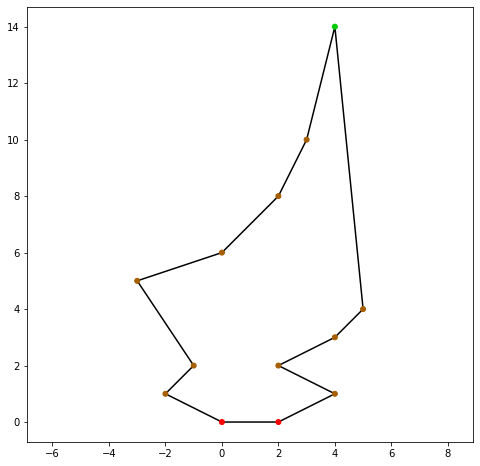

In [8]:
pol = [(0, 0), (2, 0), (4, 1), (2, 2), (4, 3), (5, 4), (4, 14), (3, 10), (2, 8), (0, 6), (-3, 5), (-1, 2), (-2, 1)]
vertices, types = unzip(VertexType.classifyVertices(pol))

x, y = unzip(vertices)
colors = list(map(VertexType.getColor, types))

prepPlot()
plt.plot(enclose(x), enclose(y), color="black", zorder=2)
plt.scatter(x, y, color=colors, zorder=3)

# Podział na łańcuchy

In [9]:
def chainSplit(polygon):
    indices = [i for i in range(len(polygon))]
    
    key = functools.cmp_to_key(higherOnLeftCmp)
    topLeftmostIdx = min(indices, key=lambda index: key(polygon[index]))
    
    rotatedPolygon = polygon[topLeftmostIdx:] + polygon[:topLeftmostIdx]
    
    idx = 1
    while (rotatedPolygon[idx][1] <= rotatedPolygon[idx - 1][1]):
        idx += 1
    
    return rotatedPolygon[:idx], rotatedPolygon[idx:]

# Triangulacja

In [10]:
def triangulate(polygon):
    if not yMonotony(polygon):
        raise Exception("Not y-monotonic!")
        
    leftChain, rightChain = chainSplit(polygon)
    taggedPolygon = [(vertex, False) for vertex in leftChain] + [(vertex, True) for vertex in rightChain]
    key = lambda taggedVertex: functools.cmp_to_key(higherOnLeftCmp)(taggedVertex[0])
    taggedPolygon.sort(key=key)
    
    def insidePolygon(curr, prev1, prev2):
        direction = Clockwiseness.getDirection(curr[0], prev1[0], prev2[0])
        return (not curr[1] and direction == Clockwiseness.CW) or (curr[1] and direction == Clockwiseness.CCW)
    
    diagonals = []
    stack = taggedPolygon[:2]
    
    n = len(taggedPolygon)
    for i in range(2, n - 1):
        curr = taggedPolygon[i]
        prev1 = taggedPolygon[i - 1]
        prev2 = taggedPolygon[i - 2]
        
        if stack[-1][1] == curr[1]:
            last = stack.pop()
            
            while len(stack) > 0 and insidePolygon(curr, last, stack[-1]):
                last = stack.pop()
                diagonals.append((curr[0], last[0]))
                
            stack.append(last)
            stack.append(curr)
        else:
            for vertex in stack[1:]:
                diagonals.append((curr[0], vertex[0]))
                
            stack = [prev1, curr]
            
    for vertex in stack[1:-1]:
        diagonals.append((taggedPolygon[-1][0], vertex[0]))
            
    return diagonals

def triangulateAnimated(polygon, ax):
    if not yMonotony(polygon):
        raise Exception("Not y-monotonic!")
        
    leftChain, rightChain = chainSplit(polygon)
    taggedPolygon = [(vertex, False) for vertex in leftChain] + [(vertex, True) for vertex in rightChain]
    key = lambda taggedVertex: functools.cmp_to_key(higherOnLeftCmp)(taggedVertex[0])
    taggedPolygon.sort(key=key)
    
    def insidePolygon(curr, prev1, prev2):
        direction = Clockwiseness.getDirection(curr[0], prev1[0], prev2[0])
        return (not curr[1] and direction == Clockwiseness.CW) or (curr[1] and direction == Clockwiseness.CCW)
    
    frames = []
        
    xPoly, yPoly = unzip(polygon)
    
    diagonals = []
    
    stack = []
    
    n = len(taggedPolygon)
    
    def plotPolygon():
        return [*ax.plot(enclose(xPoly), enclose(yPoly), color="black", zorder=2),
                ax.scatter(xPoly, yPoly, color="black", zorder=3)]
        
    def plotDiagonals():
        art = []
        for diag in diagonals:
            art += [*ax.plot([diag[0][0], diag[1][0]], [diag[0][1], diag[1][1]], color="black", linestyle="--", zorder=2)]
        return art
    
    def plotStack():
        if len(stack) > 0:
            vertices, chains = unzip(stack)
            x, y = unzip(vertices)
            return [ax.scatter(x, y, s=8 ** 2, color=list(map(lambda stack: "#478af5" if stack else "#45de37", chains)), zorder=3)]
        else:
            return []
    
    def plotN(vtx, color):
        vertices, chains = unzip(vtx)
        x, y = unzip(vertices)
        return [ax.scatter(x, y, color=color, zorder=3, s=11 ** 2)]
    
    def basicFrame():
        frame = []
        frame += plotDiagonals()
        frame += plotPolygon()
        frame += plotStack()
        return frame
    
    frames.append(basicFrame())
    
    stack = taggedPolygon[:2]
    
    for i in range(2, n - 1):
        frames.append(basicFrame())
        curr = taggedPolygon[i]
        prev1 = taggedPolygon[i - 1]
        prev2 = taggedPolygon[i - 2]
        
        if stack[-1][1] == curr[1]:
            last = stack.pop()
            
            while len(stack) > 0 and insidePolygon(curr, last, stack[-1]):
                actors = basicFrame()
                actors += plotN([curr, last, stack[-1]], "#edba02")
                frames.append(actors)
                
                last = stack.pop()
                diagonals.append((curr[0], last[0]))
                
            stack.append(last)
            stack.append(curr)
        else:
            toAdd = stack[1:]
                
            stack = [prev1, curr]
            
            actors = basicFrame()
            actors += plotN(toAdd, "#e102ed")
            frames.append(actors)
            
            for idx, vertex in enumerate(toAdd):
                diagonals.append((curr[0], vertex[0]))
                actors = basicFrame()
                actors += plotN(toAdd, "#e102ed")
                frames.append(actors)
            
    for vertex in stack[1:-1]:
        diagonals.append((taggedPolygon[-1][0], vertex[0]))
    
    stack = []
    frames.append(basicFrame())
            
    return diagonals, frames

In [32]:
%%capture
prepPlot()
fig, ax = plt.subplots()
diagonals, frames = triangulateAnimated(pol, ax)
ani = anim.ArtistAnimation(fig, frames, interval=100)

In [35]:
ani

In [13]:
triangulate(pol)

[((5, 4), (3, 10)),
 ((5, 4), (2, 8)),
 ((5, 4), (0, 6)),
 ((5, 4), (-3, 5)),
 ((4, 3), (-3, 5)),
 ((-1, 2), (4, 3)),
 ((2, 2), (-1, 2)),
 ((-2, 1), (2, 2)),
 ((4, 1), (-2, 1)),
 ((0, 0), (4, 1))]

<IPython.core.display.Javascript object>


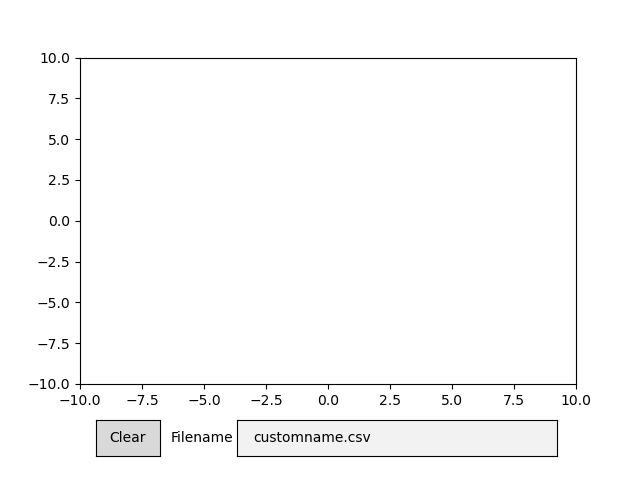

In [28]:
%matplotlib notebook
PolygonEditor()

In [30]:
%%capture
prepPlot()
fig, ax = plt.subplots()
diagonals, frames = triangulateAnimated(readFromCsv("customname.csv"), ax)
ani = anim.ArtistAnimation(fig, frames, interval=100)

In [31]:
ani